# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')


In [4]:
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [7]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [8]:
df.toPandas().skew(axis = 0, skipna = True)

itemInSession    2.480746
length           5.338281
registration    -1.586332
sessionId        0.217484
status           2.868533
ts               0.062416
dtype: float64

In [9]:
df.toPandas().kurt(axis = 0, skipna = True)

itemInSession     9.961081
length           85.489538
registration      3.205200
sessionId        -1.309083
status            6.573906
ts               -1.172516
dtype: float64

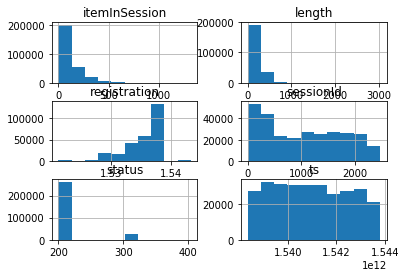

In [10]:
df.toPandas().hist();

In [11]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [12]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [13]:
df.count()

286500

In [14]:
# check for empty sessionId values
df.filter(df.sessionId == '').count()

0

In [15]:
# check for empty userId values
df.filter(df.userId == '').count()

8346

In [16]:
# check for duplicates in userId
df.select("userId").dropDuplicates().count()

226

In [17]:
# check for duplicates in sessionId
df.select("sessionId").dropDuplicates().count()

2354

In [18]:
# drop userId fields that have empty values
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_clean = df_clean.filter(df_clean["userId"] != "")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [19]:
# Churn is a label for user who have confirmed cancellation

churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())

df_clean = df_clean.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))

In [20]:
df_pandas = df_clean.toPandas()

##### User Agent extraction and count

In [21]:
# get browser specific details
def get_browser(x):
    '''
    Args:
        userAgent text value
    Returns:
        Browser value
    '''
    
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN
    

In [22]:
platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}

In [23]:
df_pandas['browser'] = df_pandas['userAgent'].apply(get_browser)

In [24]:
df_pandas['platform'] = df_pandas['userAgent'].str.extract(r'\(([^\)]*)\)')[0].str.split(';').str[0].map(platform_dict)

In [25]:
# convert to pandas dataframe
df_clean = spark.createDataFrame(df_pandas)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,downgraded,cancelled,browser,platform
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,Firefox,Windows
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,0,Chrome,Windows
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,Firefox,Windows
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,0,Chrome,Windows
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,Firefox,Windows


In [70]:
df_pandas = df_clean.toPandas()
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,downgraded,cancelled,browser,platform
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,Firefox,Windows
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,0,Chrome,Windows
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,Firefox,Windows
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,0,Chrome,Windows
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,0,Firefox,Windows


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [26]:
df_pandas.drop_duplicates(subset='userId').groupby(['downgraded'])['userId'].count()

downgraded
0    225
Name: userId, dtype: int64

In [27]:
df_pandas.drop_duplicates(subset='userId').groupby(['cancelled'])['userId'].count()

cancelled
0    225
Name: userId, dtype: int64

In [28]:
downgraded_Users = list(df_pandas[df_pandas['page'] == 'Submit Downgrade']['userId'].unique())
downgraded_Users.extend(list(df_pandas[df_pandas['page'] == 'Cancellation Confirmation']['userId'].unique()))
downgraded_Users = list(set(downgraded_Users))

In [29]:
unique_userIds = df_pandas['userId'].unique().tolist()
gender = []
for userId in unique_userIds:
    gender.append(df_pandas[df_pandas['userId'] == userId]['gender'].iloc[0])
df_gender = pd.DataFrame({'userId': unique_userIds, 'gender': gender})
df_gender = pd.DataFrame({'userId': unique_userIds, 'gender': gender})
df_gender['churn'] = df_gender['userId'].apply(lambda x: 1 if x in downgraded_Users else 0)

In [30]:
df_gender.head()

,userId,gender,churn
0,30,M,1
1,9,M,1
2,74,F,1
3,54,F,1
4,4,M,0


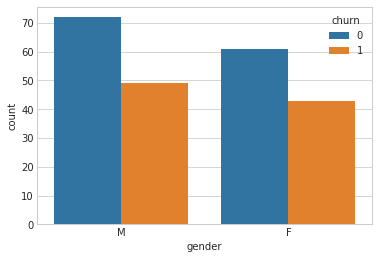

In [31]:
# churn with respect to gender
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
sns.countplot(x = "gender", hue = "churn", data = df_gender);

In [32]:
#Constructing dataframe to visualize churn with respect to level
level = []
for userId in unique_userIds:
    level.append(df_pandas[df_pandas['userId'] == userId]['level'].iloc[0])
df_level = pd.DataFrame({'userId': unique_userIds, 'level': level})
df_level['churn'] = df_gender['userId'].apply(lambda x: 1 if x in downgraded_Users else 0)
df_level.head()

,userId,level,churn
0,30,paid,1
1,9,free,1
2,74,free,1
3,54,paid,1
4,4,free,0


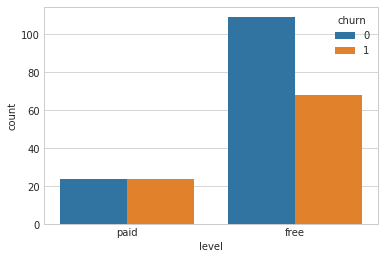

In [33]:
sns.countplot(x = "level", hue = "churn", data = df_level);

In [34]:
df_clean.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==0)&(col("cancelled")==1))\
    .count()

43

In [35]:
#number of paid users to drop without downgrading -> big chunk of those
print(df_clean.filter((col('cancelled')==1) & (col('downgraded')==0) & (col('level')=='paid'))\
      .select('userId').dropDuplicates().count())

31


In [36]:
#Creating SQL view to manipulate the data

df_clean.createOrReplaceTempView("sqlTable")

In [37]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM sqlTable
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender_count.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



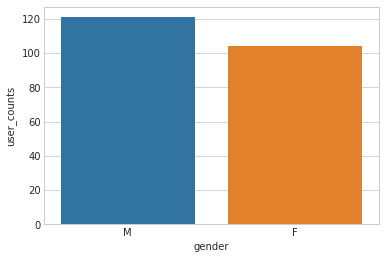

In [38]:
sns.barplot(x='gender',y='user_counts',data=gender_count.toPandas());

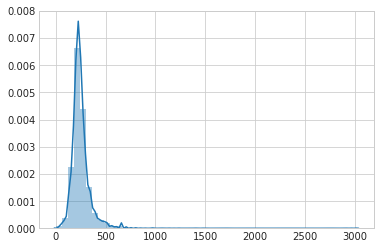

In [39]:
#concentration of length of songs
length_data = spark.sql('''
        SELECT length
        FROM sqlTable
''')

sns.distplot(length_data.toPandas().dropna());

In [40]:
# Get user level type and no of users

user_type = spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM sqlTable
        GROUP BY level
        ORDER BY user_counts DESC
''')
user_type.show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



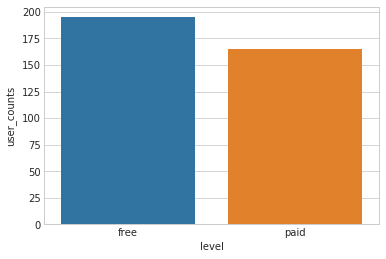

In [41]:
sns.barplot(x='level',y='user_counts',data=user_type.toPandas());

In [42]:
location_count = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_counts
        FROM sqlTable
        GROUP BY location
        ORDER BY user_counts DESC
''').toPandas()
#split city and state
location_count = location_count.join(location_count['location'].str.split(',',expand=True).rename(columns={0:'city',1:'state'})).drop('location',axis=1)
location_count.head()

,user_counts,city,state
0,16,Los Angeles-Long Beach-Anaheim,CA
1,15,New York-Newark-Jersey City,NY-NJ-PA
2,7,Phoenix-Mesa-Scottsdale,AZ
3,7,Dallas-Fort Worth-Arlington,TX
4,6,St. Louis,MO-IL


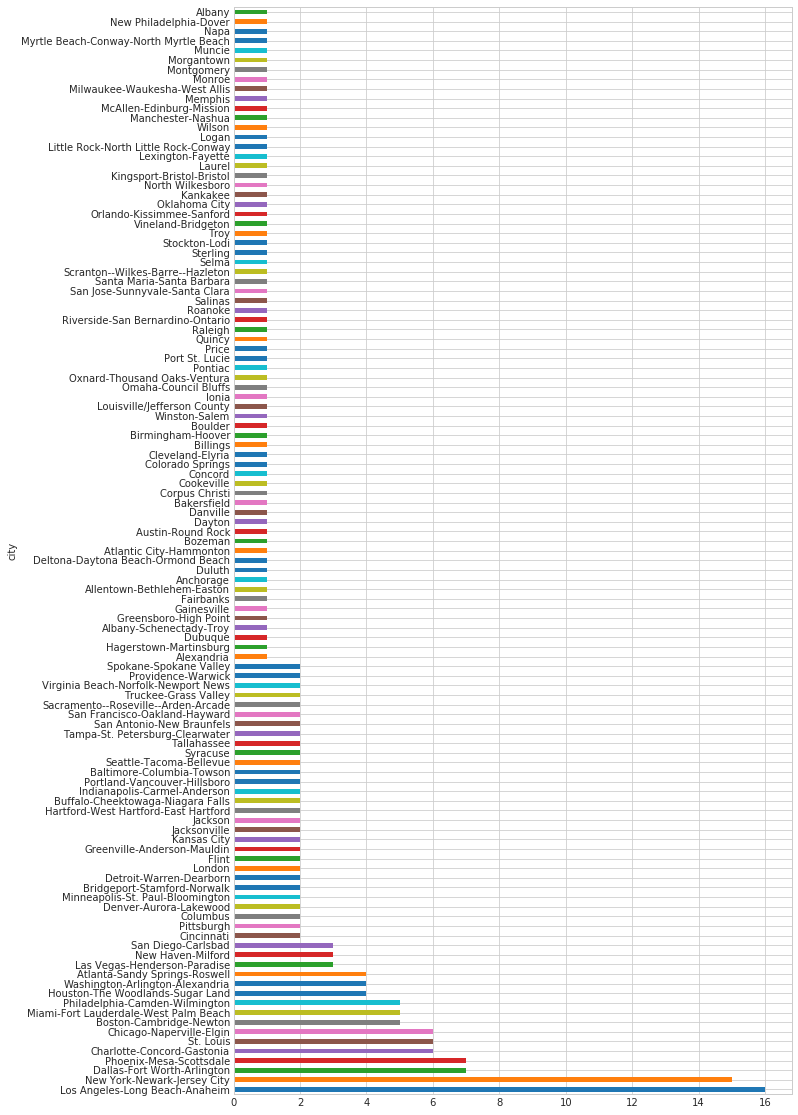

In [43]:
location_count.groupby('city')['user_counts'].sum().sort_values(ascending=False).plot(kind='barh',figsize=(10,20));

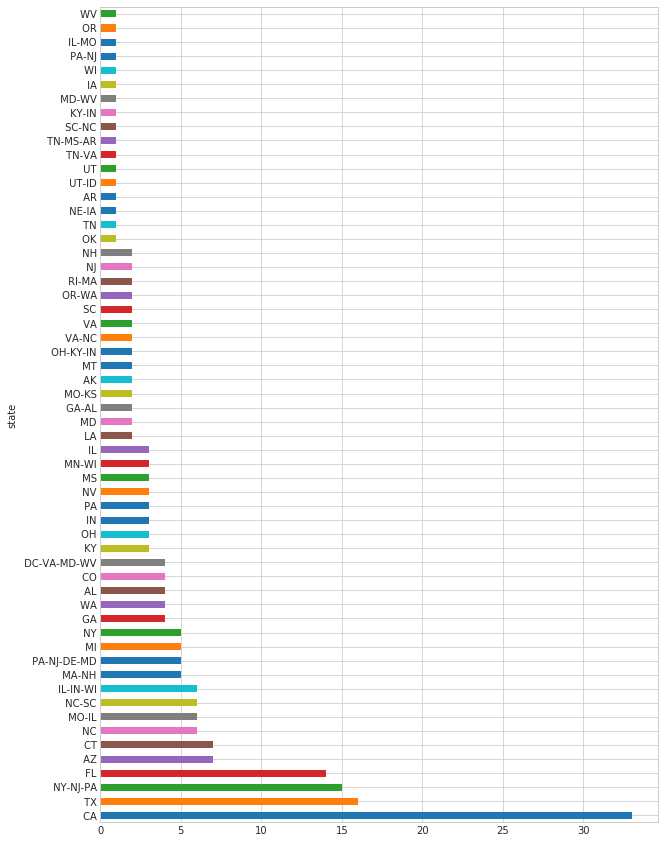

In [44]:
location_count.groupby('state')['user_counts'].sum().sort_values(ascending=False).plot(kind='barh',figsize=(10,15));

* Los Angeles and New York are top cities which have the largest user count, 
* California is the top state has the largest user count followed by Taxas.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

##### Average Number of songs per user session

In [45]:
number_of_sessions = spark.sql("SELECT userId, avg(count) as average from (SELECT userId, count(*) as count FROM sqlTable group by sessionId, userId) group by userId")
number_of_sessions.show()

+------+------------------+
|userId|           average|
+------+------------------+
|200002|              79.0|
|100010| 54.42857142857143|
|   125|              11.0|
|     7|28.714285714285715|
|   124| 166.3793103448276|
|    51|             246.4|
|    15|151.86666666666667|
|    54| 92.89189189189189|
|   155|             167.0|
|100014|51.666666666666664|
|   132|             144.0|
|   154|39.333333333333336|
|   101|             214.9|
|    11|              53.0|
|300017| 70.28571428571429|
|   138|             164.6|
|    29|105.97058823529412|
|    69|149.11111111111111|
|100021|              63.8|
|    42| 90.57446808510639|
+------+------------------+
only showing top 20 rows



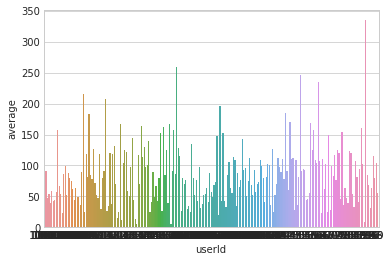

In [46]:
sns.barplot(x='userId',y='average',data=number_of_sessions.toPandas());

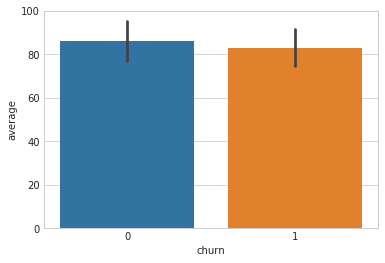

In [47]:
pd_number_of_sessions = number_of_sessions.toPandas()
pd_number_of_sessions['churn'] = pd_number_of_sessions['userId'].apply(lambda x: 1 if x in downgraded_Users else 0)
sns.barplot(x="churn", y="average", data=pd_number_of_sessions);

##### Total Songs played by user

In [48]:
total_songs = spark.sql("SELECT userId, count(*) as count_total_songs FROM sqlTable group by userId")
total_songs.show()

+------+-----------------+
|userId|count_total_songs|
+------+-----------------+
|100010|              381|
|200002|              474|
|   125|               11|
|    51|             2464|
|   124|             4825|
|     7|              201|
|    54|             3437|
|    15|             2278|
|   155|             1002|
|   132|             2304|
|   154|              118|
|100014|              310|
|   101|             2149|
|    11|              848|
|   138|             2469|
|300017|             4428|
|    29|             3603|
|    69|             1342|
|100021|              319|
|    42|             4257|
+------+-----------------+
only showing top 20 rows



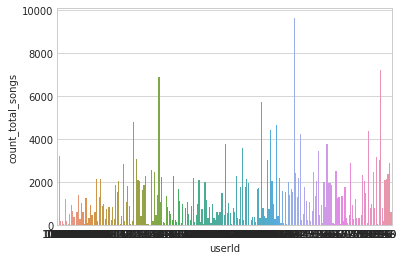

In [49]:
sns.barplot(x='userId',y='count_total_songs',data=total_songs.toPandas());

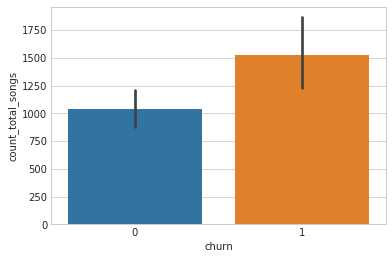

In [50]:
pd_total_songs = total_songs.toPandas()
pd_total_songs['churn'] = pd_total_songs['userId'].apply(lambda x: 1 if x in downgraded_Users else 0)
sns.barplot(x="churn", y="count_total_songs", data=pd_total_songs);

##### Thumbs Down for each user

In [51]:
thumbs_down = spark.sql("SELECT userId, count(*) as count_thumbs_down FROM sqlTable where page = 'Thumbs Down' group by userId")
thumbs_down.show()

+------+-----------------+
|userId|count_thumbs_down|
+------+-----------------+
|100010|                5|
|200002|                6|
|    51|               21|
|   124|               41|
|     7|                1|
|    15|               14|
|    54|               29|
|   155|                3|
|   132|               17|
|100014|                3|
|   101|               16|
|    11|                9|
|   138|               24|
|300017|               28|
|    29|               22|
|    69|                9|
|100021|                5|
|    42|               25|
|   112|                3|
|    73|                7|
+------+-----------------+
only showing top 20 rows



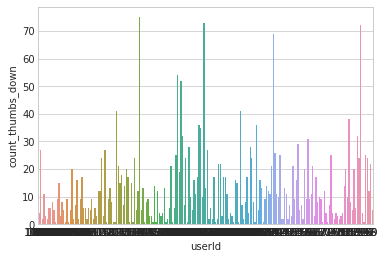

In [52]:
sns.barplot(x='userId',y='count_thumbs_down',data=thumbs_down.toPandas());

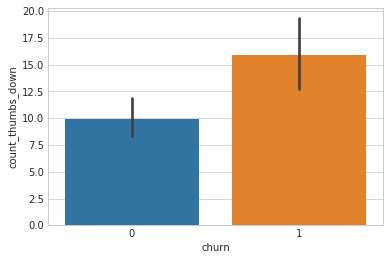

In [53]:
pd_thumbs_down = thumbs_down.toPandas()
pd_thumbs_down['churn'] = pd_thumbs_down['userId'].apply(lambda x: 1 if x in downgraded_Users else 0)
sns.barplot(x="churn", y="count_thumbs_down", data=pd_thumbs_down);

In [54]:
thumbs_up = spark.sql("SELECT userId, count(*) as count_thumbs_up FROM sqlTable where page = 'Thumbs Up' group by userId")
thumbs_up.show()

+------+---------------+
|userId|count_thumbs_up|
+------+---------------+
|100010|             17|
|200002|             21|
|    51|            100|
|   124|            171|
|     7|              7|
|    54|            163|
|    15|             81|
|   155|             58|
|   132|             96|
|   154|             11|
|100014|             17|
|   101|             86|
|    11|             40|
|   138|             95|
|300017|            303|
|    29|            154|
|    69|             72|
|100021|             11|
|    42|            166|
|   112|              9|
+------+---------------+
only showing top 20 rows



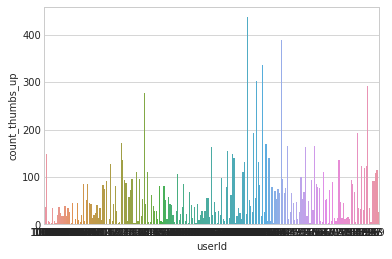

In [55]:
sns.barplot(x='userId',y='count_thumbs_up',data=thumbs_up.toPandas());

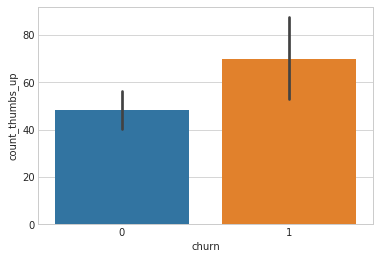

In [56]:
pd_thumbs_up = thumbs_up.toPandas()
pd_thumbs_up['churn'] = pd_thumbs_up['userId'].apply(lambda x: 1 if x in downgraded_Users else 0)
sns.barplot(x="churn", y="count_thumbs_up", data=pd_thumbs_up);

##### Number of songs couldn't be played due to errors

In [57]:
errors = spark.sql("SELECT userId, count(*) as count_errors FROM sqlTable where page = 'Error' group by userId")
errors.show()

+------+------------+
|userId|count_errors|
+------+------------+
|   124|           6|
|    51|           1|
|     7|           1|
|    15|           2|
|    54|           1|
|   155|           3|
|   132|           3|
|   101|           3|
|    11|           1|
|   138|           1|
|300017|           5|
|    69|           4|
|100021|           2|
|    42|           7|
|    73|           1|
|200010|           1|
|    30|           1|
|   113|           3|
|    59|           4|
|   146|           1|
+------+------------+
only showing top 20 rows



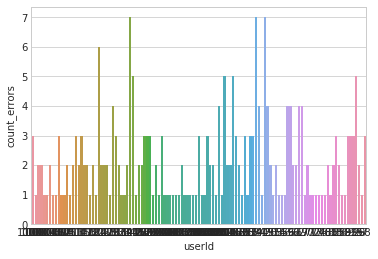

In [58]:
sns.barplot(x='userId',y='count_errors',data=errors.toPandas());

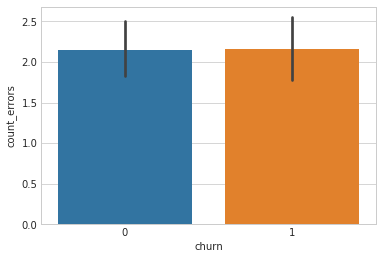

In [59]:
pd_errors = errors.toPandas()
pd_errors['churn'] = pd_thumbs_up['userId'].apply(lambda x: 1 if x in downgraded_Users else 0)
sns.barplot(x="churn", y="count_errors", data=pd_errors);

##### Number of times user opted for help

In [60]:
asked_help = spark.sql("SELECT userId, count(*) as count_help FROM sqlTable where page = 'Help' group by userId")
asked_help.show();

+------+----------+
|userId|count_help|
+------+----------+
|100010|         2|
|200002|         2|
|    51|        12|
|   124|        23|
|     7|         1|
|    54|        17|
|    15|         8|
|   155|         9|
|   132|        16|
|   154|         1|
|100014|         2|
|   101|        12|
|    11|         3|
|   138|        13|
|300017|        27|
|    29|        28|
|    69|         7|
|   112|         1|
|    42|        20|
|    73|         4|
+------+----------+
only showing top 20 rows



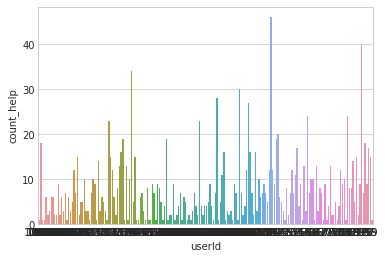

In [61]:
sns.barplot(x='userId',y='count_help',data=asked_help.toPandas());

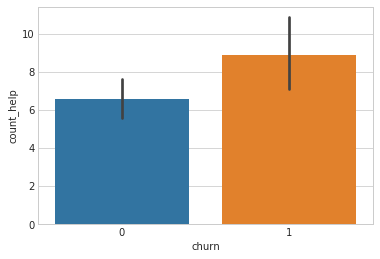

In [62]:
pd_asked_help = asked_help.toPandas()
pd_asked_help['churn'] = pd_asked_help['userId'].apply(lambda x: 1 if x in downgraded_Users else 0)
sns.barplot(x="churn", y="count_help", data=pd_asked_help);

##### Number of events per user to add friend

In [63]:
add_friend = spark.sql("SELECT userId, count(*) as count_add_friend FROM sqlTable where page = 'Add Friend' group by userId")
add_friend.show();

+------+----------------+
|userId|count_add_friend|
+------+----------------+
|100010|               4|
|200002|               4|
|    51|              28|
|   124|              74|
|     7|               1|
|    54|              33|
|    15|              31|
|   155|              11|
|   132|              41|
|   154|               3|
|100014|               6|
|   101|              29|
|    11|               6|
|   138|              41|
|300017|              63|
|    29|              47|
|    69|              12|
|100021|               7|
|    42|              52|
|   112|               7|
+------+----------------+
only showing top 20 rows



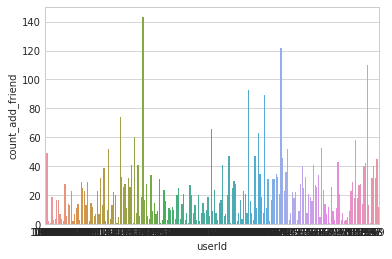

In [64]:
sns.barplot(x='userId',y='count_add_friend',data=add_friend.toPandas());

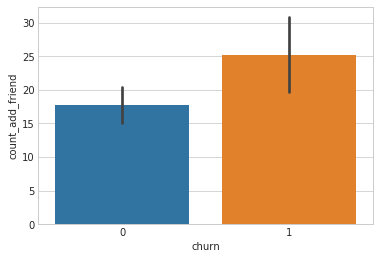

In [65]:
pd_add_friend = add_friend.toPandas()
pd_add_friend['churn'] = pd_add_friend['userId'].apply(lambda x: 1 if x in downgraded_Users else 0)
sns.barplot(x="churn", y="count_add_friend", data=pd_add_friend);

##### Getting Number of events per user based on Browser agent and platform agent

In [73]:
browser_agent = spark.sql("SELECT browser, COUNT(DISTINCT userId) AS user_counts FROM sqlTable GROUP BY browser ORDER BY user_counts DESC")
browser_agent.show();

+-------+-----------+
|browser|user_counts|
+-------+-----------+
| Chrome|        117|
|Firefox|         50|
| Safari|         46|
|     IE|         12|
+-------+-----------+



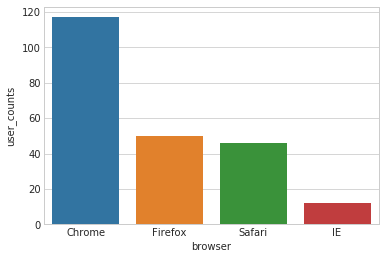

In [74]:
pd_browser_agent = browser_agent.toPandas()
pd_browser_agent['churn'] = pd_browser_agent['browser'].apply(lambda x: 1 if x in downgraded_Users else 0)
sns.barplot(x="browser", y="user_counts", data=pd_browser_agent);

In [75]:
platform_agent = spark.sql("SELECT platform, COUNT(DISTINCT userId) AS user_counts FROM sqlTable GROUP BY platform ORDER BY user_counts DESC")
platform_agent.show();

+--------+-----------+
|platform|user_counts|
+--------+-----------+
| Windows|        111|
|     Mac|         86|
|  iPhone|         13|
|   Linux|         12|
|    iPad|          3|
+--------+-----------+



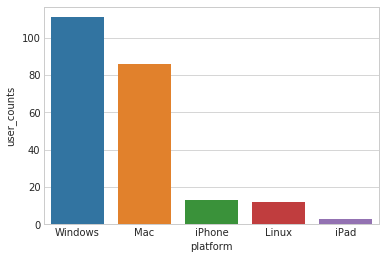

In [77]:
pd_platform_agent = platform_agent.toPandas()
pd_platform_agent['churn'] = pd_platform_agent['platform'].apply(lambda x: 1 if x in downgraded_Users else 0)
sns.barplot(x="platform", y="user_counts", data=pd_platform_agent);

In [78]:
total_windows_user = spark.sql("SELECT userId, count(*) AS windows_user_count FROM sqlTable WHERE platform = 'Windows' GROUP BY userId")
total_windows_user.show();

+------+------------------+
|userId|windows_user_count|
+------+------------------+
|    51|              2464|
|     7|               201|
|    54|              3437|
|    15|              2278|
|   155|              1002|
|   154|               118|
|100014|               310|
|   101|              2149|
|    11|               848|
|    69|              1342|
|    42|              4257|
|   112|               292|
|    87|              1003|
|    73|               457|
|     3|               254|
|    30|              1775|
|   133|                44|
|    59|               872|
|   146|               837|
|     8|               334|
+------+------------------+
only showing top 20 rows



In [79]:
total_Mac_user = spark.sql("SELECT userId, count(*) AS mac_user_count FROM sqlTable WHERE platform = 'Mac' GROUP BY userId")
total_Mac_user.show();

+------+--------------+
|userId|mac_user_count|
+------+--------------+
|   125|            11|
|   124|          4825|
|   132|          2304|
|300017|          4428|
|    29|          3603|
|100021|           319|
|    64|            68|
|   113|          1895|
|    34|            73|
|300018|          2046|
|100022|           964|
|    85|          4370|
|    35|          2005|
|    71|           329|
|    98|          2891|
|    47|           251|
|100008|           940|
|100025|           623|
|   110|           235|
|300006|           379|
+------+--------------+
only showing top 20 rows



In [85]:
total_iPhone_user = spark.sql("SELECT userId, count(*) AS iPhone_user_count FROM sqlTable WHERE platform = 'iPhone' GROUP BY userId")
total_iPhone_user.show();

+------+-----------------+
|userId|iPhone_user_count|
+------+-----------------+
|100010|              381|
|200002|              474|
|   139|              457|
|300008|             1672|
|    61|             1976|
|300015|             3051|
|200018|              478|
|    79|              321|
|    32|              108|
|100017|               75|
|   123|              196|
|    13|             1654|
|200015|              349|
+------+-----------------+



In [86]:
total_linux_user = spark.sql("SELECT userId, count(*) AS linux_user_count FROM sqlTable WHERE platform = 'Linux' GROUP BY userId")
total_linux_user.show();

+------+----------------+
|userId|linux_user_count|
+------+----------------+
|200010|             317|
|300013|             411|
|300007|             143|
|200024|             552|
|100016|             638|
|   122|              62|
|100019|              89|
|300022|             446|
|    65|            2544|
|   121|             916|
|    83|            1496|
|   145|            1347|
+------+----------------+



In [87]:
total_iPad_user = spark.sql("SELECT userId, count(*) AS iPad_user_count FROM sqlTable WHERE platform = 'iPad' GROUP BY userId")
total_iPad_user.show();

+------+---------------+
|userId|iPad_user_count|
+------+---------------+
|   138|           2469|
|    92|           7230|
|   152|           1682|
+------+---------------+



In [88]:
pd_total_windows_user = total_windows_user.toPandas()
pd_total_Mac_user = total_Mac_user.toPandas()
pd_total_iPhone_user = total_iPhone_user.toPandas()
pd_total_linux_user = total_linux_user.toPandas()
pd_total_iPad_user = total_iPad_user.toPandas()

In [89]:
total_chrome_user = spark.sql("SELECT userId, count(*) AS chrome_user_count FROM sqlTable WHERE browser = 'Chrome' GROUP BY userId")
total_chrome_user.show();

+------+-----------------+
|userId|chrome_user_count|
+------+-----------------+
|   125|               11|
|    51|             2464|
|   124|             4825|
|    15|             2278|
|   155|             1002|
|   154|              118|
|100014|              310|
|    69|             1342|
|    42|             4257|
|    87|             1003|
|    64|               68|
|     3|              254|
|   113|             1895|
|    34|               73|
|   133|               44|
|   146|              837|
|     8|              334|
|300018|             2046|
|300012|              786|
|    85|             4370|
+------+-----------------+
only showing top 20 rows



In [90]:
total_firefox_user = spark.sql("SELECT userId, count(*) AS firefox_user_count FROM sqlTable WHERE browser = 'Firefox' GROUP BY userId")
total_firefox_user.show();

+------+------------------+
|userId|firefox_user_count|
+------+------------------+
|     7|               201|
|    54|              3437|
|   101|              2149|
|   112|               292|
|    73|               457|
|200010|               317|
|    30|              1775|
|    59|               872|
|100022|               964|
|    52|              1363|
|    71|               329|
|    47|               251|
|100008|               940|
|   107|               315|
|300002|              1961|
|   100|              3214|
|    17|              1102|
|    26|               337|
|    60|              1950|
|300024|               102|
+------+------------------+
only showing top 20 rows



In [91]:
total_safari_user = spark.sql("SELECT userId, count(*) AS safari_user_count FROM sqlTable WHERE browser = 'Safari' GROUP BY userId")
total_safari_user.show();

+------+-----------------+
|userId|safari_user_count|
+------+-----------------+
|100010|              381|
|200002|              474|
|   132|             2304|
|   138|             2469|
|300017|             4428|
|    29|             3603|
|100021|              319|
|   139|              457|
|    35|             2005|
|300008|             1672|
|    18|              513|
|    61|             1976|
|   131|             1863|
|300015|             3051|
|   136|             2567|
|200014|              982|
|   128|             2067|
|    55|              489|
|    38|             1570|
|    44|              512|
+------+-----------------+
only showing top 20 rows



In [92]:
total_ie_user = spark.sql("SELECT userId, count(*) AS ie_user_count FROM sqlTable WHERE browser = 'IE' GROUP BY userId")
total_ie_user.show();

+------+-------------+
|userId|ie_user_count|
+------+-------------+
|    11|          848|
|    28|         1781|
|    22|           40|
|   147|          672|
|300011|         5732|
|100004|         1245|
|    19|          259|
|    41|         2220|
|    93|          815|
|300003|           35|
|    84|           97|
|300025|         1603|
+------+-------------+



In [93]:
pd_total_chrome_user = total_chrome_user.toPandas()
pd_total_firefox_user = total_firefox_user.toPandas()
pd_total_safari_user = total_safari_user.toPandas()
pd_total_ie_user = total_ie_user.toPandas()

##### Joining all data frames to construct a unified which can be fed to machine lerning algorithms

In [ ]:
temp_df = thumbs_down.join(thumbs_up, thumbs_down.userId == thumbs_up.userId).drop(thumbs_up.userId)
temp_df = temp_df.join(errors, errors.userId == temp_df.userId).drop(errors.userId)
temp_df = temp_df.join(asked_help, asked_help.userId == temp_df.userId).drop(asked_help.userId)
temp_df = temp_df.join(add_friend, add_friend.userId == temp_df.userId).drop(add_friend.userId)
temp_df = temp_df.join(total_songs, total_songs.userId == temp_df.userId).drop(total_songs.userId)
temp_df = temp_df.join(number_of_sessions, number_of_sessions.userId == temp_df.userId).drop(number_of_sessions.userId)

temp_df = temp_df.join(add_friend, add_friend.userId == temp_df.userId).drop(add_friend.userId)
temp_df = temp_df.join(add_friend, add_friend.userId == temp_df.userId).drop(add_friend.userId)
temp_df = temp_df.join(add_friend, add_friend.userId == temp_df.userId).drop(add_friend.userId)
temp_df = temp_df.join(add_friend, add_friend.userId == temp_df.userId).drop(add_friend.userId)
temp_df = temp_df.join(add_friend, add_friend.userId == temp_df.userId).drop(add_friend.userId)
temp_df = temp_df.join(add_friend, add_friend.userId == temp_df.userId).drop(add_friend.userId)
temp_df = temp_df.join(add_friend, add_friend.userId == temp_df.userId).drop(add_friend.userId)
temp_df = temp_df.join(add_friend, add_friend.userId == temp_df.userId).drop(add_friend.userId)
temp_df = temp_df.join(add_friend, add_friend.userId == temp_df.userId).drop(add_friend.userId)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.